

---


***NAMES: Lorenzo Ricciardulli (ID: 5309594), Ilaria Crippa (ID: 5306565)***



---



# LIBRARIES

In [ ]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [ ]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
from matplotlib import pyplot as plt
import time

In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0  # notice the precise version
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
d2l.use_svg_display()
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DEEP LEARNING
#!unzip "skin-cancer-mnist-ham10000.zip"
%ls

/content/drive/.shortcut-targets-by-id/1l1fk8soMmtm9SQh_zJcaTl5n6VlWfN4M/DEEP LEARNING
 accuracy_plot.png                                              HAM10000_images_part_2/
 best_model.pth                                                 HAM10000_metadata.csv
 best_model_regr2.pth                                           hmnist_28_28_L.csv
 best_model_regr3.pth                                           hmnist_28_28_L.gsheet
 best_model_regr.pth                                            hmnist_28_28_RGB.csv
 classification_metrics.png                                     hmnist_8_8_L.csv
 classification_metrics_table.png                               hmnist_8_8_RGB.csv
 confusion_matrix_percentage.png                                kaggle.json
 confusion_matrix.png                                           loss_plot.png
'Copia di Deep Learning 2 MNIST skin dataset di ILARIA.ipynb'   melanoma_cancer_dataset/
'Copia di Deep Learning.ipynb'                                  runs/
'Deep Le

# THE DATASET

The dataset consists of 10015 dermatoscopic images. It has been downloaded from Kaggle (https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000).    
It is a collection of all important diagnostic categories in the realm of pigmented lesions:  
*  actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
*  basal cell carcinoma (bcc),
*  benign keratosis-like lesions (bkl),
*  dermatofibroma (df),
*  melanoma (mel),
*  melanocytic nevi (nv)
*  vascular lesions (vasc).  

It includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

The dataset was originally split into two folders, that have to be joined by constructing an image path for each image, based on the image_id's found in the metadata csv file. The paths are then stored in the metadata dataframe.  
We can observe that the lesion_id column, which is a unique identifier for each lesion, has duplicates. This is due to the fact that some lesions have multiple images with different angles, lighting conditions, or imaging devices.  
Therefore, checking for duplicate lesion_ids is crucial for data splitting, model training, and evaluation to avoid overfitting and ensuring proper Cross-Validation.

In [ ]:
import os
import pandas as pd
metadata_path = os.path.join('HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
base1_path = 'ham10000_images_part_1'
base2_path = 'ham10000_images_part_2'

image_paths = []

for index, row in metadata.iterrows():
    image_id = row['image_id']

    image_path_1 = os.path.join(base1_path, f'{image_id}.jpg')
    image_path_2 = os.path.join(base2_path, f'{image_id}.jpg')

    if os.path.exists(image_path_1):
        image_paths.append(image_path_1)
    elif os.path.exists(image_path_2):
        image_paths.append(image_path_2)
    else:
        print(f'Image {image_id} not found in either path.')

metadata['image_path'] = image_paths
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ham10000_images_part_2/ISIC_0031633.jpg


Now we create a dictionary that maps the skin lesion type of the column 'dx' to the full name of the pathology based on the description of the dataset. Furthermore, we create a column that maps the skin lesion to an integer to convert the variable of interest into a categorical variable for the classification task. This will be useful to check the number of classes and their distribution.

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

metadata['cell_type'] = metadata['dx'].map(lesion_type_dict.get)
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes

metadata.sample(4)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,cell_type,cell_type_idx
4334,HAM_0000997,ISIC_0030385,nv,follow_up,75.0,female,trunk,ham10000_images_part_2/ISIC_0030385.jpg,Melanocytic nevi,4
2885,HAM_0005617,ISIC_0024833,bcc,histo,65.0,male,back,ham10000_images_part_1/ISIC_0024833.jpg,Basal cell carcinoma,1
5023,HAM_0005788,ISIC_0031828,nv,follow_up,55.0,female,trunk,ham10000_images_part_2/ISIC_0031828.jpg,Melanocytic nevi,4
9253,HAM_0001329,ISIC_0029879,nv,consensus,40.0,female,lower extremity,ham10000_images_part_2/ISIC_0029879.jpg,Melanocytic nevi,4


<Axes: xlabel='cell_type'>

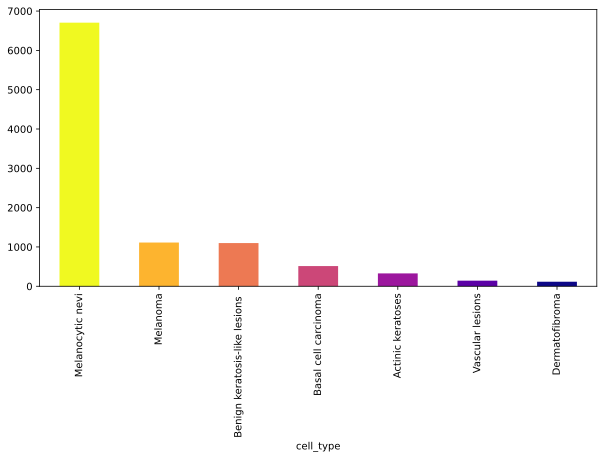

In [ ]:
import matplotlib.cm as cm
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
colors = cm.plasma(np.linspace(0, 1, metadata['cell_type'].nunique()))[::-1]
metadata['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=colors)

In [ ]:
metadata['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,6705
Melanoma,1113
Benign keratosis-like lesions,1099
Basal cell carcinoma,514
Actinic keratoses,327
Vascular lesions,142
Dermatofibroma,115


It can be noticed that there is an issue of class imbalance: two classes contain less than 150 images each, while the most represented group (Melanocytic nevi) contains more than 6700 images. This problem can be later solved with data augmentation.

The second problem that will be adressed is a regression task to predict the age of the patients from the same images.  
From the plot below, we can notice that the distribution of the age variable is slightly skewed to the right, since there are many more patients that are older than 40 compared to younger patients.  
The oldest registered patient is 85 years old, while the youngest has not yet turned 1.

In [ ]:
print(min(metadata['age']))
print(max(metadata['age']))

0.0
85.0


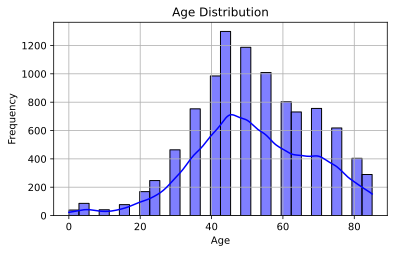

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 3.5))
sns.histplot(metadata['age'], bins=30, kde=True, color='blue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.grid(True)
plt.show()

  Now, we restructure the dataset to make it compatible with the ImageFolder method, load the images and display some for each class.

In [ ]:
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

We define the base directory that will contain the images and all the subfolders for the train, validation and test splits. Each of these three subfolders will contain 7 folders for each skin lesion type.

In [ ]:
#base_dir = "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000"

#split_dirs = ["train", "val", "test"]
#class_labels = metadata["dx"].unique().tolist()

#os.makedirs(base_dir, exist_ok=True)

#for split in split_dirs:
    #for label in class_labels:
        #os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

print("Directory structure created successfully")

Directory structure created successfully


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (110 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import tree

!tree -d "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000"

/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000
├── test
│   ├── akiec
│   ├── bcc
│   ├── bkl
│   ├── df
│   ├── mel
│   ├── nv
│   └── vasc
├── train
│   ├── akiec
│   ├── bcc
│   ├── bkl
│   ├── df
│   ├── mel
│   ├── nv
│   └── vasc
└── val
    ├── akiec
    ├── bcc
    ├── bkl
    ├── df
    ├── mel
    ├── nv
    └── vasc

24 directories


Now, since we know that there are duplicates in the lesion_id column, we have to make sure that the images with the same id (i.e. the images with different angles and lighting of the same skin lesion) fall in the same dataset split, so to avoid data leakage.  
The train set amounts to 70% of the images, and the validation and test splits amount to 15% of the dataset each.

In [ ]:
grouped = metadata.groupby("lesion_id")

lesion_ids = list(grouped.groups.keys())

train_ids, test_ids = train_test_split(lesion_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

lesion_split_map = {lid: "train" for lid in train_ids}
lesion_split_map.update({lid: "val" for lid in val_ids})
lesion_split_map.update({lid: "test" for lid in test_ids})

metadata["split"] = metadata["lesion_id"].map(lesion_split_map)

metadata["split"].value_counts()

,count
split,
train,7002
val,1522
test,1491


Finally, we move the images to their respective folders based on their "image_path".

In [ ]:
#base_dir = "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000"

#for _, row in metadata.iterrows():
    #src_path = row["image_path"]
    #split = row["split"]
    #class_folder = row["dx"]

    #dest_path = os.path.join(base_dir, split, class_folder, os.path.basename(src_path))

    #shutil.move(src_path, dest_path)

print("Images successfully moved into train/val/test folders!")

Images successfully moved into train/val/test folders!


Now we try to visualize some images, first with a random batch from the train set and then one image per class.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_augmentation = transforms.Compose([transforms.ToTensor()])

train_dir = "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000/train"
train_set = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [ ]:
seed = 63
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
import random
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

some_example_set = data.DataLoader(train_set, batch_size=9, shuffle=True, worker_init_fn=lambda _: np.random.seed(seed))
data_iter = iter(some_example_set) #Creates an iterator from the some_example_set DataLoader

In [ ]:
X, y = next(data_iter)
print(train_set[0][0].shape)
print(X.shape) # X is (batch_size, channels, img height, img width)
print(y.shape)
print(y) # y: 0-based index values representing class labels of the minibatch
print(torch.is_tensor(X[0]))

torch.Size([3, 450, 600])
torch.Size([9, 3, 450, 600])
torch.Size([9])
tensor([4, 5, 5, 5, 2, 5, 2, 5, 4])
True


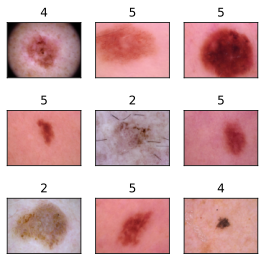

In [ ]:
X = X.permute(0, 2, 3, 1)
_ = d2l.show_images(X, 3, 3, titles=[str(int(label)) for label in y])

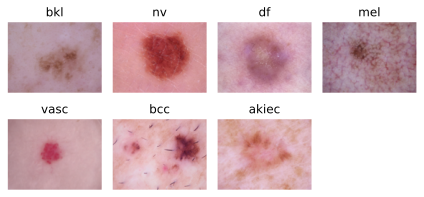

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread

seed = 123
np.random.seed(seed)
random.seed(seed)

classes = metadata['dx'].unique()

random_image_ids = []
for cls in classes:
    class_metadata = metadata[metadata['dx'] == cls]
    random_image_id = class_metadata.sample(1)['image_id'].values[0]
    random_image_ids.append(random_image_id)

image_paths = []
for image_id in random_image_ids:
    image_path = metadata[metadata['image_id'] == image_id]['image_path'].values[0]
    image_paths.append(image_path)

figure = plt.figure(figsize=(6, 3))
cols, rows = 4, 2
for i, image_path in enumerate(image_paths):
    img = imread(image_path)

    ax = figure.add_subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis("off")

    class_name = metadata[metadata['image_path'] == image_path]['dx'].values[0]
    ax.set_title(class_name)

plt.tight_layout()
plt.show()

## DATA AUGMENTATION

Before training the models, we have to solve the issue of class imbalance.  
One possible solution is to implement a weighted random sampler when using the DataLoader.  
The class weights are calculated as the reciprocal of class counts and then used to sample the images.

In [ ]:
from torch.utils.data import WeightedRandomSampler

class_counts = np.bincount(train_set.targets)
class_weights = 1. / class_counts
sample_weights = class_weights[train_set.targets]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In addition to class weights, a data augmentation strategy is used with transforms.Compose, in order to add random transformations to the images.  

The applied transformations are:
*  a random rotation of 30 degrees
*  a random crop of the image to resize it to (224, 224)
*  random horizontal flip, to make the model invariant to left-right orientation
*  color jitter, which randomly modified brightness, contrast, saturation and hue values
*  conversion to tensor

In [ ]:
data_augmentation = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])

train_dir = "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000/train"
train_set = datasets.ImageFolder(root=train_dir, transform=data_augmentation)

Below, we can see 9 images from a random batch after the data augmentation and the implementation of class weights.

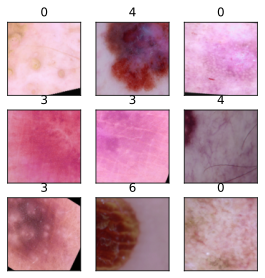

In [ ]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler, worker_init_fn=lambda _: np.random.seed(seed))
data_iter = iter(train_loader)
X, y = next(data_iter)
X = X.permute(0, 2, 3, 1)
_ = d2l.show_images(X, 3, 3, titles=[str(int(label)) for label in y])

In order to make sure that the class weights used in the DataLoader are working as expencted, we can compare the counts of each class drawn in 7 random batches with the function defined below.

In [ ]:
def visualise_dataloader(dl, id_to_label=None, with_outputs=True, num_batches=7):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    idx_to_label = {i: key for i, key in enumerate(sorted(id_to_label.keys()))}

    class_counts_per_batch = {key: [0] * num_batches for key in id_to_label.keys()}

    for i, batch in enumerate(dl):
        if i >= num_batches:
            break

        images, labels = batch

        idxs = list(range(len(images)))
        class_ids, class_counts = labels.unique(return_counts=True)

        idxs_seen.extend(idxs)

        for class_id, count in zip(class_ids.tolist(), class_counts.tolist()):
            class_key = idx_to_label[class_id]
            class_counts_per_batch[class_key][i] = count

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 10))

        ind = np.arange(num_batches)
        width = 0.12
        colors = plt.cm.plasma(np.linspace(0, 1, len(class_counts_per_batch)))

        for i, (class_key, counts) in enumerate(class_counts_per_batch.items()):
            ax.bar(ind + width * i, counts, width, label=id_to_label[class_key], color=colors[i])

        ax.set_xticks(ind)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)

        plt.legend()
        plt.show()

Below, we can see that images are drawn with similar frequency when using class weights (first plot) compared to when they are randomly shuffled (second plot).
In the second plot, the most represented class is Melanocytic nevi, which contains 58 times more images than the smallest class.

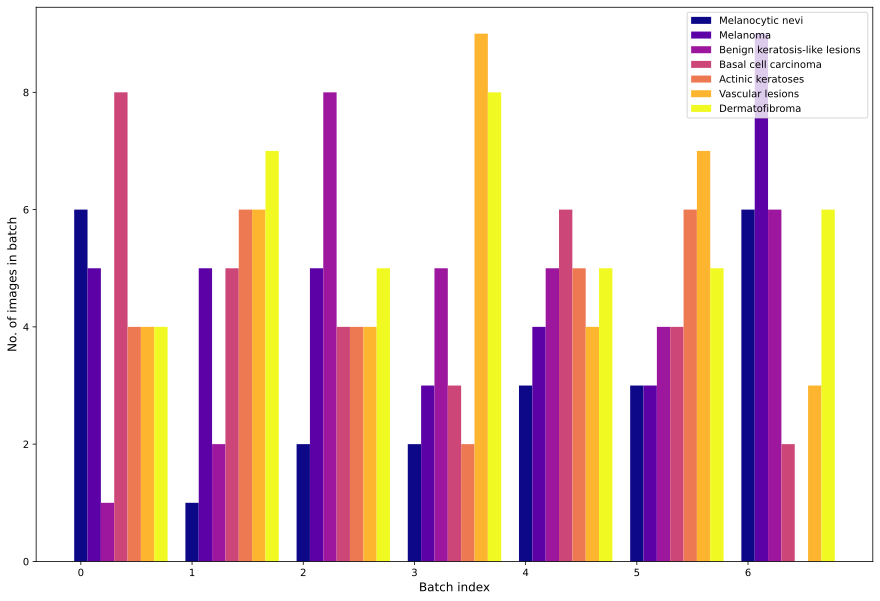

In [ ]:
visualise_dataloader(train_loader, lesion_type_dict, with_outputs=True, num_batches=7)

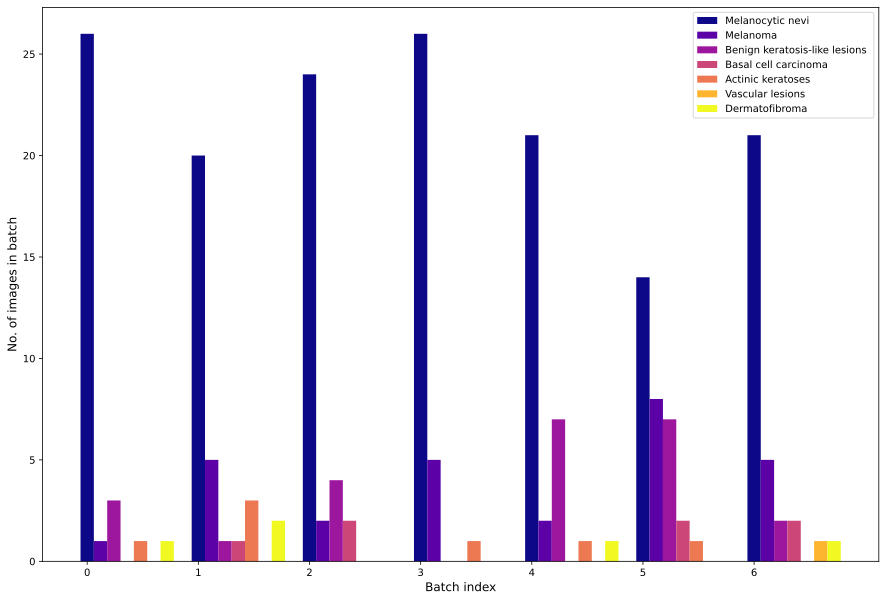

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
visualise_dataloader(train_loader, lesion_type_dict, with_outputs=True, num_batches=7)

A dictionary mapping class labels and class names is defined to conclude the preparation step before the classification model definition.

In [ ]:
idx_to_label = {i: key for i, key in enumerate(sorted(lesion_type_dict.keys()))}
idx_to_label

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

# FIRST MODEL

***NOTE: this is the first model that we have trained. The second file contains the second model.***

In [ ]:
from typing import Dict, Any
from pathlib import Path
import os

In order to set a regresion problem with images, we apply some changes to the `ImageFolder` class, a built-in PyTorch dataset class, that automatically loads images from a folder structure and sets the target value as the subfolder name they are stored in.    
The new class `RegressionImageFolder` extends `ImageFolder` to handle continuous target values, with a dictionary that maps image file paths to their corresponding target values (for regression).

The image paths are reconstructed based on the image_id column of the metadata.

In [ ]:
base_path = 'skin_lesions_10000'

image_paths = []

for index, row in metadata.iterrows():
    image_id = row['image_id']
    split = row['split']
    category = row['dx']

    image_path = os.path.join(base_path, split, category, f'{image_id}.jpg')

    if os.path.exists(image_path):
        image_paths.append(image_path)
    else:
        print(f'Image {image_id} not found in either path.')

metadata['image_path'] = image_paths

metadata['image_path'] = metadata['image_path'].apply(
    lambda path: os.path.join(path.split(os.sep)[-2], f'{path.split(os.sep)[-1]}')
)

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,cell_type,cell_type_idx,split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,bkl/ISIC_0027419.jpg,Benign keratosis-like lesions,2,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,bkl/ISIC_0025030.jpg,Benign keratosis-like lesions,2,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,bkl/ISIC_0026769.jpg,Benign keratosis-like lesions,2,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,bkl/ISIC_0025661.jpg,Benign keratosis-like lesions,2,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,bkl/ISIC_0031633.jpg,Benign keratosis-like lesions,2,train


The dictionary that maps the paths of train data to the respective target value of the patients' age is defined.  
The are some NaN values in the 'age' column of the metadata csv file. They are removed when creating the dictionary that maps the train set image paths to the age values, to ensure that the train function will work properly.

In [ ]:
import math

image_dict = {}

for index, row in metadata.iterrows():
    if row['split'] == 'train' and not math.isnan(row['age']):
      image_dict[row['image_path']] = row['age']

print(image_dict)

{'bkl/ISIC_0027419.jpg': 80.0, 'bkl/ISIC_0025030.jpg': 80.0, 'bkl/ISIC_0026769.jpg': 80.0, 'bkl/ISIC_0025661.jpg': 80.0, 'bkl/ISIC_0031633.jpg': 75.0, 'bkl/ISIC_0027850.jpg': 75.0, 'bkl/ISIC_0025837.jpg': 70.0, 'bkl/ISIC_0025209.jpg': 70.0, 'bkl/ISIC_0025276.jpg': 55.0, 'bkl/ISIC_0029396.jpg': 85.0, 'bkl/ISIC_0025984.jpg': 85.0, 'bkl/ISIC_0025915.jpg': 75.0, 'bkl/ISIC_0031029.jpg': 75.0, 'bkl/ISIC_0032343.jpg': 70.0, 'bkl/ISIC_0025033.jpg': 60.0, 'bkl/ISIC_0027310.jpg': 60.0, 'bkl/ISIC_0032128.jpg': 75.0, 'bkl/ISIC_0025937.jpg': 75.0, 'bkl/ISIC_0027828.jpg': 40.0, 'bkl/ISIC_0029291.jpg': 40.0, 'bkl/ISIC_0030698.jpg': 40.0, 'bkl/ISIC_0025567.jpg': 40.0, 'bkl/ISIC_0031753.jpg': 70.0, 'bkl/ISIC_0026835.jpg': 70.0, 'bkl/ISIC_0024981.jpg': 80.0, 'bkl/ISIC_0029161.jpg': 60.0, 'bkl/ISIC_0026273.jpg': 60.0, 'bkl/ISIC_0025076.jpg': 50.0, 'bkl/ISIC_0029687.jpg': 50.0, 'bkl/ISIC_0025642.jpg': 50.0, 'bkl/ISIC_0031691.jpg': 40.0, 'bkl/ISIC_0025419.jpg': 40.0, 'bkl/ISIC_0030105.jpg': 80.0, 'bkl/ISIC

The mappings between ages and images are created by using the following class.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Dict, Any

In [ ]:
class RegressionImageFolder(datasets.ImageFolder):
    """
    A subclass of ImageFolder for regression tasks. Instead of using class subfolders,
    it maps image paths to target values using the provided dictionary.
    """
    def __init__(self, root: str, image_targets: dict, *args, **kwargs):
        super().__init__(root, *args, **kwargs)

        paths, _ = zip(*self.imgs)

        targets = []
        valid_paths = []
        for path in paths:
            relative_path = str(os.path.relpath(path, start=root))
            if relative_path in image_targets:
                targets.append(image_targets[relative_path])
                valid_paths.append(path)

        self.targets = torch.tensor(targets, dtype=torch.float32)

        self.samples = list(zip(valid_paths, self.targets))

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000/train'
train_data = RegressionImageFolder(
    root = root,
    image_targets = image_dict,
    transform =data_augmentation
)

I create a sample batch sampled randomly.  
The shape of the batch is (batch_size, 3 for the color channels, H, W) and the target tensor contains continuous values instead of class labels, which is exactly the result we were expecting.

In [ ]:
dataloader = DataLoader(train_data, batch_size=4, shuffle=True)

images, targets = next(iter(dataloader))

print(f"Batch image shape: {images.shape}")
print(targets)

NameError: name 'train_data' is not defined

Some images of the batch can be displayed with their target values.

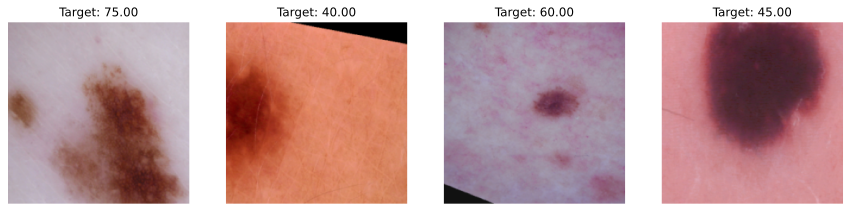

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Target: {targets[i].item():.2f}")
    axes[i].axis("off")
plt.show()

# THE ARCHITECTURE

The model is structured with 3 convolutional blocks composed of Conv2d layers, batch normalization and maxpooling.  
The Conv2d layer uses:  
*  16 filters of size 3x3, for edge and texture extraction
*  a stride of 1, which ensures fine-grained feature extraction
*  padding of 1 to maintain the same spatial dimensions

BatchNormalization normalizes activations to stabilize training and speed up convergence, while MaxPool2d reduces spatial dimensions by a factor of 2, making the model computationally efficient while retaining important features.
   
The second convolutional block contains a Conv2d layer that implements larger kernels of size 5x5, to extract more complex features, such as shapes and patterns. It also doubles the number of filters, allowing the model to learn more diverse patterns and randomly deactivates 20% of neurons through dropout, preventing overfitting.  
  
The output channels of the third convolutional layer of the third block increases the number of output channels once again, while MaxPool2d further reduces the spatial size, ensuring efficiency.  
  
Finally, the first fully connected layer connects the extracted features to 128 neurons, learning high-level patterns; the layer normalization normalizes activations across each sample and a higher dropout rate is used before the final layer to prevent overfitting.  
The second linear layer outputs a single continuous value for the regression task.  

    
.  

The forward method defines how the input flows through the network and implements ReLU activation functions after each block, which help the network learn non-linear patterns efficiently.

During fine-tuning, the structure of the model has been modified various times, for instance, by editing the out_channels, the droput and kernel sizes, by using AdaptiveAvgPool2d instead of MaxPool2d, by increasing the depth of the model and using some variations of the ReLU, like ELU and Leaky ReLU.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from typing import Tuple

In [ ]:
class CNNRegression(nn.Module):
    """
    This will be the CNN model we will use for the regression task.
    """
    def __init__(self, image_size: Tuple[int, int, int] = (3, 224, 224)):
        super(CNNRegression, self).__init__()
        self.image_size = image_size

        self.conv1 = nn.Conv2d(in_channels=self.image_size[0], out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.2)

        # Dynamically calculate the linear line size based on the image size
        def calculate_linear_line_size(image_size):
            with torch.no_grad():
                x = torch.zeros(1, *image_size)
                x = self.dropout3(self.pool3(self.bn3(self.conv3(self.dropout2(self.pool2(self.bn2(self.conv2(self.pool1(self.bn1(self.conv1(x)))))))))))
                return x.numel()

        self.linear_line_size = calculate_linear_line_size(self.image_size)
        self.fc1 = nn.Linear(in_features=self.linear_line_size, out_features=128)
        self.bn4 = nn.LayerNorm(128)
        self.dropout4 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    def forward(self, x):
        """
        Passes the data through the network.
        """

        print(f'Input shape: {x.shape}')

        x = self.conv1(x)
        print('Size of tensor after each layer')
        print(f'conv1 {x.size()}')

        x = self.bn1(x)

        x = nn.functional.relu(x)
        print(f'relu1 {x.size()}')

        x = self.pool1(x)
        print(f'pool1 {x.size()}')

        x = self.conv2(x)
        print(f'conv2 {x.size()}')

        x = self.bn2(x)
        print(f'bn2 {x.size()}')

        x = nn.functional.relu(x)
        print(f'relu2 {x.size()}')

        x = self.pool2(x)
        print(f'pool2 {x.size()}')

        x = self.dropout2(x)
        print(f'dropout2 {x.size()}')

        x = self.conv3(x)
        print(f'conv3 {x.size()}')

        x = self.bn3(x)
        print(f'bn3 {x.size()}')

        x = nn.functional.relu(x)
        print(f'relu3 {x.size()}')

        x = self.pool3(x)
        print(f'pool3 {x.size()}')

        x = self.dropout3(x)
        print(f'dropout3 {x.size()}')


        x = x.view(x.shape[0], -1)
        print(f'view1 {x.size()}')

        x = self.fc1(x)
        print(f'fc1 {x.size()}')

        x = self.bn4(x)
        print(f'bn4 {x.size()}')

        x = nn.functional.relu(x)
        print(f'relu4 {x.size()}')

        x = self.dropout4(x)
        print(f'dropout4 {x.size()}')

        x = self.fc2(x)
        print(f'fc2 {x.size()}')

        return x

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNRegression().to(device)

print(next(model.parameters()).device)  #print cuda:0 if successful


cuda:0


The output dimensions can be printed.

In [ ]:
X = torch.rand(size=(2, 3, 224, 224), dtype=torch.float32).to(device)
model = CNNRegression(image_size=(3, 224, 224)).to(device)

output = model(X)

Input shape: torch.Size([2, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([2, 16, 224, 224])
relu1 torch.Size([2, 16, 224, 224])
pool1 torch.Size([2, 16, 112, 112])
conv2 torch.Size([2, 32, 112, 112])
bn2 torch.Size([2, 32, 112, 112])
relu2 torch.Size([2, 32, 112, 112])
pool2 torch.Size([2, 32, 56, 56])
dropout2 torch.Size([2, 32, 56, 56])
conv3 torch.Size([2, 64, 56, 56])
bn3 torch.Size([2, 64, 56, 56])
relu3 torch.Size([2, 64, 56, 56])
pool3 torch.Size([2, 64, 28, 28])
dropout3 torch.Size([2, 64, 28, 28])
view1 torch.Size([2, 50176])
fc1 torch.Size([2, 128])
bn4 torch.Size([2, 128])
relu4 torch.Size([2, 128])
dropout4 torch.Size([2, 128])
fc2 torch.Size([2, 1])


As for the data augmentation strategy applied to the validation set, only the resize is transformation is used in addition to the tensor transformation.

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
import math

image_dict_val = {}

for index, row in metadata.iterrows():
    if row['split'] == 'val' and not math.isnan(row['age']):
      image_dict_val[row['image_path']] = row['age']

print(image_dict_val)

{'bkl/ISIC_0025767.jpg': 70.0, 'bkl/ISIC_0032417.jpg': 70.0, 'bkl/ISIC_0031159.jpg': 60.0, 'bkl/ISIC_0031017.jpg': 60.0, 'bkl/ISIC_0025016.jpg': 75.0, 'bkl/ISIC_0029147.jpg': 75.0, 'bkl/ISIC_0031468.jpg': 75.0, 'bkl/ISIC_0030926.jpg': 75.0, 'bkl/ISIC_0029288.jpg': 75.0, 'bkl/ISIC_0031008.jpg': 75.0, 'bkl/ISIC_0031495.jpg': 40.0, 'bkl/ISIC_0026104.jpg': 40.0, 'bkl/ISIC_0033539.jpg': 60.0, 'bkl/ISIC_0032283.jpg': 75.0, 'bkl/ISIC_0030005.jpg': 75.0, 'bkl/ISIC_0030189.jpg': 75.0, 'bkl/ISIC_0026532.jpg': 75.0, 'bkl/ISIC_0024832.jpg': 40.0, 'bkl/ISIC_0026958.jpg': 40.0, 'bkl/ISIC_0029022.jpg': 70.0, 'bkl/ISIC_0032463.jpg': 75.0, 'bkl/ISIC_0025548.jpg': 75.0, 'bkl/ISIC_0032304.jpg': 65.0, 'bkl/ISIC_0031639.jpg': 65.0, 'bkl/ISIC_0032382.jpg': 55.0, 'bkl/ISIC_0027533.jpg': 55.0, 'bkl/ISIC_0026794.jpg': 60.0, 'bkl/ISIC_0030276.jpg': 60.0, 'bkl/ISIC_0032877.jpg': 80.0, 'bkl/ISIC_0034175.jpg': 80.0, 'bkl/ISIC_0033523.jpg': 80.0, 'bkl/ISIC_0033280.jpg': 50.0, 'bkl/ISIC_0033212.jpg': 50.0, 'bkl/ISIC

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000/val'
val_data = RegressionImageFolder(
    root = root,
    image_targets = image_dict_val,
    transform =val_transforms
)

Finally, the batch size is set to 256 (various batch sizes have been used to experiment during training, based on validation results).

In [ ]:
batch_size = 256
train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_iter = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

NameError: name 'train_data' is not defined

The following train function trains a CNN regression model using PyTorch and evaluates it on a validation set. It includes weight initialization, loss tracking, model checkpointing, and early stopping.  

It uses Kaiming Normal Initialization for the initial weights, which helps improve training for deep networks using ReLU activations.  

The Mean Squared Error (MSE) loss is used, since this is a regression task, with Adam optimizer (other optimizers, like SGD with momentum and RMSProp were used, but were much slower to converge). A learning rate scheduler was also implemented in some train runs, but I later decided to discard it.  

The lowest validation loss is tracked for early stopping. Then, there is a forward pass that uses the model to predict the ouput values, followed by a backward pass after loss computation, to compute gradients via backpropagation and updates model weights.  

During evaluation phase, the model is swithed to evaluation mode, disabling dropout, to compute validation loss.


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from tqdm import tqdm

def train_network(device, train_iter, val_iter, n_epochs: int = 10, image_size: tuple = (3, 100, 100), lr: float = 0.001):
    """
    Trains the network for a set number of epochs and evaluates the model on a test set.
    """
    assert image_size[1] == image_size[2], 'Image size must be square'

    model = CNNRegression(image_size=image_size).to(device)

    def init_weights(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)

    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4)

    train_losses = []
    val_losses = []

    writer = SummaryWriter()

    best_val_loss = float('inf')
    patience, epochs_without_improvement = 9, 0

    for epoch in range(n_epochs):
        model.train()
        train_loss, all_outputs, all_targets = 0.0, [], []

        progress_bar = tqdm(train_iter, desc=f'Epoch {epoch+1}/{n_epochs}', ncols=100)

        for i, (inputs, targets) in enumerate(progress_bar):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.shape[0]
            writer.add_scalar('Train Loss', loss.item(), epoch * len(train_iter) + i)

        #scheduler.step()

        train_loss /= len(train_iter.dataset)

        train_losses.append(train_loss)

        print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}')

        # ====== Validation ======
        model.eval()
        val_loss, val_outputs, val_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, targets in val_iter:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() * inputs.shape[0]

        val_loss /= len(val_iter.dataset)

        val_losses.append(val_loss)

        print(f'Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model_regr.pth")
            print("✅ Model improved, saved!")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"⏳ Early stopping triggered. No improvement in {patience} epochs.")
            break

        writer.add_scalar('Validation Loss', val_loss, epoch)

    print("\nFinal Training Summary")
    print("=" * 50)
    print("Epoch | Train Loss | Validation Loss")
    print("-" * 50)

    for epoch in range(len(train_losses)):
        print(f"{epoch+1:5} | {train_losses[epoch]:10.4f} | {val_losses[epoch]:10.4f}")

    print("=" * 50)

    writer.close()
    return model

The final learning rate was set to 0.01, although different values were set to experiment with during training and validation.

In [ ]:
from torch.optim import Adam
from torch.optim import RMSprop
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr, num_epochs = 0.01, 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_network(device=device, train_iter=train_iter, n_epochs=num_epochs, image_size = (3, 224, 224), lr=lr, val_iter=val_iter)

Epoch 1/20: 100%|███████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]

Epoch [1/20], Train Loss: 466.6861


Validation Loss: 303.2852
✅ Model improved, saved!


Epoch 2/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [2/20], Train Loss: 323.9513


Validation Loss: 305.7820


Epoch 3/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [3/20], Train Loss: 317.5712


Validation Loss: 303.0055
✅ Model improved, saved!


Epoch 4/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [4/20], Train Loss: 312.5654


Validation Loss: 296.7999
✅ Model improved, saved!


Epoch 5/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [5/20], Train Loss: 309.7020


Validation Loss: 295.2018
✅ Model improved, saved!


Epoch 6/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [6/20], Train Loss: 305.7565


Validation Loss: 301.2538


Epoch 7/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [7/20], Train Loss: 304.9515


Validation Loss: 289.1855
✅ Model improved, saved!


Epoch 8/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [8/20], Train Loss: 302.3466


Validation Loss: 289.7839


Epoch 9/20: 100%|███████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.39s/it]

Epoch [9/20], Train Loss: 306.7274


Validation Loss: 292.0268


Epoch 10/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch [10/20], Train Loss: 297.0116


Validation Loss: 285.9960
✅ Model improved, saved!


Epoch 11/20: 100%|██████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.35s/it]

Epoch [11/20], Train Loss: 298.3813


Validation Loss: 277.0522
✅ Model improved, saved!


Epoch 12/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [12/20], Train Loss: 295.6333


Validation Loss: 295.4657


Epoch 13/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [13/20], Train Loss: 290.5991


Validation Loss: 280.3416


Epoch 14/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.39s/it]

Epoch [14/20], Train Loss: 288.7401


Validation Loss: 269.9969
✅ Model improved, saved!


Epoch 15/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [15/20], Train Loss: 287.9455


Validation Loss: 261.3050
✅ Model improved, saved!


Epoch 16/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch [16/20], Train Loss: 284.0611


Validation Loss: 254.9072
✅ Model improved, saved!


Epoch 17/20: 100%|██████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.35s/it]

Epoch [17/20], Train Loss: 283.7284


Validation Loss: 257.4865


Epoch 18/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch [18/20], Train Loss: 284.5380


Validation Loss: 275.3975


Epoch 19/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]

Epoch [19/20], Train Loss: 282.0105


Validation Loss: 260.1626


Epoch 20/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [20/20], Train Loss: 283.1103


Validation Loss: 270.8532

Final Training Summary
Epoch | Train Loss | Validation Loss
--------------------------------------------------
    1 |   466.6861 |   303.2852
    2 |   323.9513 |   305.7820
    3 |   317.5712 |   303.0055
    4 |   312.5654 |   296.7999
    5 |   309.7020 |   295.2018
    6 |   305.7565 |   301.2538
    7 |   304.9515 |   289.1855
    8 |   302.3466 |   289.7839
    9 |   306.7274 |   292.0268
   10 |   297.0116 |   285.9960
   11 |   298.3813 |   277.0522
   12 |   295.6333 |   295.4657
   13 |   290.5991 |   280.3416
   14 |   288.7401 |   269.9969
   15 |   287.9455 |   261.3050
   16 |   284.0611 |   254.9072
   17 |   283.7284 |   257.4865
   18 |   284.5380 |   275.3975
   19 |   282.0105 |   260.1626
   20 |   283.1103 |   270.8532


CNNRegression(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (bn4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout4): D

A visualization of train and validation MSE values can aid us in understanding the training process.


In [ ]:
train_losses = [
    466.6861, 323.9513, 317.5712, 312.5654, 309.7020,
    305.7565, 304.9515, 302.3466, 306.7274, 297.0116,
    298.3813, 295.6333, 290.5991, 288.7401, 287.9455,
    284.0611, 283.7284, 284.5380, 282.0105, 283.1103
]

validation_losses = [
    303.2852, 305.7820, 303.0055, 296.7999, 295.2018,
    301.2538, 289.1855, 289.7839, 292.0268, 285.9960,
    277.0522, 295.4657, 280.3416, 269.9969, 261.3050,
    254.9072, 257.4865, 275.3975, 260.1626, 270.8532
]

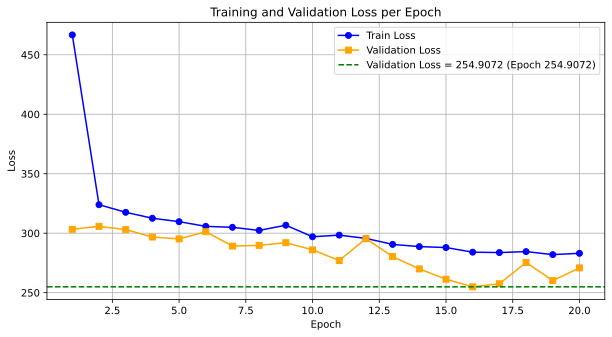

In [ ]:
epochs = np.arange(1, len(train_losses) + 1)

min_val_loss = min(validation_losses)
min_epoch = np.argmin(validation_losses) + 1

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(epochs, validation_losses, label="Validation Loss", color='orange', marker='s')

plt.axhline(y=min_val_loss, color='green', linestyle='--', label=f'Validation Loss = 254.9072 (Epoch {min_val_loss})')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)

plt.show()

The train loss started from a high value compared to the validation loss, but it quickly decreased. On the other hand, some oscillations can be noticed in the validation loss, in particular towards the last epochs. Therefore, the model weights were saved when the validation loss hit the lowest value.  
Additionaly, the validation loss maintained values lower the train loss, meaning that the model was not overfitting.  
The lowest MSE value achieved was 254.9, indicating that the model's predictions deviate, on average, by approximately 15.97 years (sqrt(254.9)) from the true values.  
This suggests that the model's performance may need improvement, although an extensive fine-tuning process was applied, as the errors are relatively large in the context of predicting age.  
An issue with this result may be outliers, whose influence is amplified, since the error terms in MSE grow quadratically.

# PREDICTIONS ON TEST SET

In [ ]:
image_dict_test = {}

for index, row in metadata.iterrows():
    if row['split'] == 'test' and not math.isnan(row['age']):
      image_dict_test[row['image_path']] = row['age']

print(image_dict_test)

{'bkl/ISIC_0029176.jpg': 60.0, 'bkl/ISIC_0029068.jpg': 60.0, 'bkl/ISIC_0031326.jpg': 65.0, 'bkl/ISIC_0029836.jpg': 70.0, 'bkl/ISIC_0032129.jpg': 70.0, 'bkl/ISIC_0027815.jpg': 80.0, 'bkl/ISIC_0024324.jpg': 85.0, 'bkl/ISIC_0029559.jpg': 85.0, 'bkl/ISIC_0030661.jpg': 85.0, 'bkl/ISIC_0027053.jpg': 85.0, 'bkl/ISIC_0028560.jpg': 85.0, 'bkl/ISIC_0031650.jpg': 85.0, 'bkl/ISIC_0025819.jpg': 75.0, 'bkl/ISIC_0032013.jpg': 75.0, 'bkl/ISIC_0027960.jpg': 75.0, 'bkl/ISIC_0026955.jpg': 75.0, 'bkl/ISIC_0029413.jpg': 70.0, 'bkl/ISIC_0029576.jpg': 70.0, 'bkl/ISIC_0027957.jpg': 50.0, 'bkl/ISIC_0031212.jpg': 50.0, 'bkl/ISIC_0034318.jpg': 55.0, 'bkl/ISIC_0032972.jpg': 55.0, 'bkl/ISIC_0032949.jpg': 85.0, 'bkl/ISIC_0033322.jpg': 85.0, 'bkl/ISIC_0033127.jpg': 85.0, 'bkl/ISIC_0033646.jpg': 50.0, 'bkl/ISIC_0033592.jpg': 50.0, 'bkl/ISIC_0033899.jpg': 50.0, 'bkl/ISIC_0029929.jpg': 80.0, 'bkl/ISIC_0033437.jpg': 60.0, 'bkl/ISIC_0033195.jpg': 60.0, 'bkl/ISIC_0032553.jpg': 60.0, 'bkl/ISIC_0032776.jpg': 55.0, 'bkl/ISIC

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/skin_lesions_10000/test'
test_data = RegressionImageFolder(
    root = root,
    image_targets = image_dict_test,
    transform =val_transforms
)

First, the model with the trained weights is loaded. It is then set to evaluation mode, to disable dropout and batcnorm updates.

In [ ]:
model = CNNRegression(image_size=(3, 224, 224))
model.load_state_dict(torch.load("best_model_regr.pth"))
model.eval()

CNNRegression(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (bn4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout4): D

Now, the test data is loaded.

In [ ]:
test_iter = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

I perform inference on the test data, by storing the predictions without tracking gradients.

In [ ]:
import torch.nn.functional as F

predictions = []
actual_values = []

with torch.no_grad():
    for images, labels in test_iter:
        outputs = model(images)
        predictions.extend(outputs.squeeze().tolist())
        actual_values.extend(labels.tolist())

I calculate two metrics: the mean squared error and the mean absolute error.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")

MAE: 12.22, MSE: 245.16


The mean absolute error indicates that on average, the model's predictions are off by 12.22 years.  
On the other hand, the MSE is larger, meaning that large errors are being penalized more heavily, which suggests some predictions have high deviations, since the relationship between the two metric is MSE=MAE^2+Variance of Errors.  
 In conclusion, the result either suggests that large outliers exist, so some predictions are way off, or that the model has high variance, meaning that it makes very different errors for different inputs.

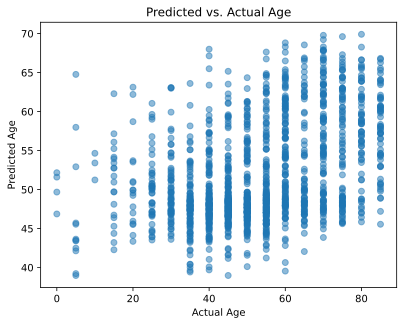

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(actual_values, predictions, alpha=0.5)
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs. Actual Age")
plt.show()

As we can see from the plot above, the model makes a lot of mistakes, in particular when predicting ages from pictures of patients that are 60 to 70  years old and patients that are not well represented in the dataset, for instance very young patients. However, there is a trend in the plotted predictions, which follow the diagonal (where actual values and predictions coincide).

Two alternative loss functions, that can be implemented to adress this issue are the Huber Loss and the SmoothL1Loss (a form of Huber loss with a customizable threshold beta). They are less sensitive to outliers than the Squared error loss.

$$
\text{SmoothL1Loss}(x, y) =
\begin{cases}
\frac{1}{2} (x - y)^2 / \beta, & \text{if } |x - y| < \beta \\
|x - y| - \frac{1}{2} \beta, & \text{otherwise}
\end{cases}
$$

In [ ]:
def train_network2(device, train_iter, val_iter, n_epochs: int = 10, image_size: tuple = (3, 100, 100), lr: float = 0.001):
    """
    Trains the network for a set number of epochs and evaluates the model on a test set.
    """
    assert image_size[1] == image_size[2], 'Image size must be square'

    model = CNNRegression(image_size=image_size).to(device)

    def init_weights(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)

    criterion = nn.SmoothL1Loss(beta=1.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    writer = SummaryWriter()

    best_val_loss = float('inf')
    patience, epochs_without_improvement = 5, 0

    for epoch in range(n_epochs):
        model.train()
        train_loss, all_outputs, all_targets = 0.0, [], []

        progress_bar = tqdm(train_iter, desc=f'Epoch {epoch+1}/{n_epochs}', ncols=100)

        for i, (inputs, targets) in enumerate(progress_bar):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.shape[0]
            writer.add_scalar('Train Loss', loss.item(), epoch * len(train_iter) + i)

        train_loss /= len(train_iter.dataset)

        train_losses.append(train_loss)

        print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}')

        # ====== Validation ======
        model.eval()
        val_loss, val_outputs, val_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, targets in val_iter:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() * inputs.shape[0]

        val_loss /= len(val_iter.dataset)

        val_losses.append(val_loss)

        print(f'Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model_regr3.pth")
            print("✅ Model improved, saved!")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"⏳ Early stopping triggered. No improvement in {patience} epochs.")
            break

        writer.add_scalar('Validation Loss', val_loss, epoch)

    print("\nFinal Training Summary")
    print("=" * 50)
    print("Epoch | Train Loss | Validation Loss")
    print("-" * 50)

    for epoch in range(len(train_losses)):
        print(f"{epoch+1:5} | {train_losses[epoch]:10.4f} | {val_losses[epoch]:10.4f}")

    print("=" * 50)

    writer.close()
    return model, train_losses, val_losses

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from tqdm import tqdm

In [ ]:
lr, num_epochs = 0.001, 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_network2(device=device, train_iter=train_iter, n_epochs=num_epochs, image_size = (3, 224, 224), lr=lr, val_iter=val_iter)

Epoch 1/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:   4%|█▊                                                  | 1/28 [00:14<06:21, 14.13s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:   7%|███▋                                                | 2/28 [00:21<04:21, 10.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  11%|█████▌                                              | 3/28 [00:28<03:33,  8.55s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  14%|███████▍                                            | 4/28 [00:34<03:08,  7.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  18%|█████████▎                                          | 5/28 [00:41<02:51,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  21%|███████████▏                                        | 6/28 [00:48<02:40,  7.27s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  25%|█████████████                                       | 7/28 [00:55<02:29,  7.11s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  29%|██████████████▊                                     | 8/28 [01:01<02:19,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  32%|████████████████▋                                   | 9/28 [01:09<02:12,  6.98s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  36%|██████████████████▏                                | 10/28 [01:15<02:03,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  39%|████████████████████                               | 11/28 [01:22<01:56,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  43%|█████████████████████▊                             | 12/28 [01:29<01:49,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  46%|███████████████████████▋                           | 13/28 [01:35<01:42,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  50%|█████████████████████████▌                         | 14/28 [01:42<01:35,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  54%|███████████████████████████▎                       | 15/28 [01:49<01:27,  6.71s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  57%|█████████████████████████████▏                     | 16/28 [01:56<01:21,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  61%|██████████████████████████████▉                    | 17/28 [02:02<01:14,  6.74s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  64%|████████████████████████████████▊                  | 18/28 [02:09<01:07,  6.75s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  68%|██████████████████████████████████▌                | 19/28 [02:16<01:00,  6.76s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  71%|████████████████████████████████████▍              | 20/28 [02:22<00:52,  6.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  75%|██████████████████████████████████████▎            | 21/28 [02:28<00:44,  6.37s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  79%|████████████████████████████████████████           | 22/28 [02:34<00:37,  6.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:40<00:30,  6.14s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:46<00:24,  6.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:52<00:18,  6.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  93%|███████████████████████████████████████████████▎   | 26/28 [02:57<00:11,  5.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 1/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:04<00:06,  6.00s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 1/20: 100%|███████████████████████████████████████████████████| 28/28 [03:05<00:00,  6.62s/it]

Epoch [1/20], Train Loss: 13.0485


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 2/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:   4%|█▊                                                  | 1/28 [00:13<06:14, 13.89s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:   7%|███▋                                                | 2/28 [00:20<04:15,  9.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  11%|█████▌                                              | 3/28 [00:27<03:31,  8.45s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  14%|███████▍                                            | 4/28 [00:34<03:06,  7.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  18%|█████████▎                                          | 5/28 [00:41<02:49,  7.38s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  21%|███████████▏                                        | 6/28 [00:47<02:38,  7.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  25%|█████████████                                       | 7/28 [00:54<02:28,  7.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  29%|██████████████▊                                     | 8/28 [01:01<02:20,  7.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  32%|████████████████▋                                   | 9/28 [01:08<02:12,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  36%|██████████████████▏                                | 10/28 [01:15<02:04,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  39%|████████████████████                               | 11/28 [01:22<01:57,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  43%|█████████████████████▊                             | 12/28 [01:28<01:49,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  46%|███████████████████████▋                           | 13/28 [01:35<01:42,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  50%|█████████████████████████▌                         | 14/28 [01:42<01:35,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  54%|███████████████████████████▎                       | 15/28 [01:49<01:29,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  57%|█████████████████████████████▏                     | 16/28 [02:00<01:36,  8.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  61%|██████████████████████████████▉                    | 17/28 [02:11<01:40,  9.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  64%|████████████████████████████████▊                  | 18/28 [02:23<01:38,  9.89s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  68%|██████████████████████████████████▌                | 19/28 [02:35<01:33, 10.41s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  71%|████████████████████████████████████▍              | 20/28 [02:45<01:22, 10.29s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  75%|██████████████████████████████████████▎            | 21/28 [02:55<01:12, 10.36s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  79%|████████████████████████████████████████           | 22/28 [03:08<01:06, 11.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  82%|█████████████████████████████████████████▉         | 23/28 [03:16<00:50, 10.19s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  86%|███████████████████████████████████████████▋       | 24/28 [03:22<00:35,  8.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  89%|█████████████████████████████████████████████▌     | 25/28 [03:28<00:24,  8.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:34<00:15,  7.50s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 2/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:41<00:07,  7.13s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 2/20: 100%|███████████████████████████████████████████████████| 28/28 [03:42<00:00,  7.95s/it]

Epoch [2/20], Train Loss: 10.8180


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 3/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:   4%|█▊                                                  | 1/28 [00:15<06:45, 15.01s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:   7%|███▋                                                | 2/28 [00:22<04:32, 10.50s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  11%|█████▌                                              | 3/28 [00:29<03:44,  8.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  14%|███████▍                                            | 4/28 [00:36<03:15,  8.15s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  18%|█████████▎                                          | 5/28 [00:43<02:59,  7.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  21%|███████████▏                                        | 6/28 [00:50<02:42,  7.40s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  25%|█████████████                                       | 7/28 [00:57<02:32,  7.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  29%|██████████████▊                                     | 8/28 [01:03<02:21,  7.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  32%|████████████████▋                                   | 9/28 [01:10<02:11,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  36%|██████████████████▏                                | 10/28 [01:17<02:04,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  39%|████████████████████                               | 11/28 [01:23<01:56,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  43%|█████████████████████▊                             | 12/28 [01:30<01:50,  6.89s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  46%|███████████████████████▋                           | 13/28 [01:37<01:41,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  50%|█████████████████████████▌                         | 14/28 [01:44<01:35,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  54%|███████████████████████████▎                       | 15/28 [01:51<01:28,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  57%|█████████████████████████████▏                     | 16/28 [01:58<01:22,  6.89s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  61%|██████████████████████████████▉                    | 17/28 [02:05<01:16,  6.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  64%|████████████████████████████████▊                  | 18/28 [02:12<01:08,  6.89s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  68%|██████████████████████████████████▌                | 19/28 [02:19<01:02,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  71%|████████████████████████████████████▍              | 20/28 [02:25<00:53,  6.66s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  75%|██████████████████████████████████████▎            | 21/28 [02:31<00:44,  6.42s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  79%|████████████████████████████████████████           | 22/28 [02:36<00:37,  6.22s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:42<00:30,  6.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:48<00:23,  5.99s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:54<00:17,  5.94s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:00<00:11,  5.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 3/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:05<00:05,  5.87s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 3/20: 100%|███████████████████████████████████████████████████| 28/28 [03:07<00:00,  6.69s/it]

Epoch [3/20], Train Loss: 10.7078


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 4/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:   4%|█▊                                                  | 1/28 [00:14<06:20, 14.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:   7%|███▋                                                | 2/28 [00:21<04:21, 10.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  11%|█████▌                                              | 3/28 [00:27<03:30,  8.41s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  14%|███████▍                                            | 4/28 [00:34<03:06,  7.78s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  18%|█████████▎                                          | 5/28 [00:41<02:51,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  21%|███████████▏                                        | 6/28 [00:48<02:40,  7.28s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  25%|█████████████                                       | 7/28 [00:55<02:31,  7.20s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  29%|██████████████▊                                     | 8/28 [01:02<02:21,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  32%|████████████████▋                                   | 9/28 [01:09<02:15,  7.13s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  36%|██████████████████▏                                | 10/28 [01:16<02:07,  7.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  39%|████████████████████                               | 11/28 [01:23<01:59,  7.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  43%|█████████████████████▊                             | 12/28 [01:30<01:52,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  46%|███████████████████████▋                           | 13/28 [01:37<01:44,  6.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  50%|█████████████████████████▌                         | 14/28 [01:44<01:37,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  54%|███████████████████████████▎                       | 15/28 [01:51<01:31,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  57%|█████████████████████████████▏                     | 16/28 [01:58<01:23,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  61%|██████████████████████████████▉                    | 17/28 [02:05<01:18,  7.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  64%|████████████████████████████████▊                  | 18/28 [02:12<01:10,  7.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  68%|██████████████████████████████████▌                | 19/28 [02:19<01:03,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  71%|████████████████████████████████████▍              | 20/28 [02:25<00:54,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  75%|██████████████████████████████████████▎            | 21/28 [02:31<00:45,  6.52s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  79%|████████████████████████████████████████           | 22/28 [02:37<00:38,  6.40s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:43<00:31,  6.22s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:49<00:24,  6.15s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:55<00:18,  6.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:01<00:12,  6.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 4/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:07<00:06,  6.02s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 4/20: 100%|███████████████████████████████████████████████████| 28/28 [03:08<00:00,  6.74s/it]

Epoch [4/20], Train Loss: 10.6485


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 5/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:   4%|█▊                                                  | 1/28 [00:14<06:19, 14.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:   7%|███▋                                                | 2/28 [00:21<04:19,  9.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  11%|█████▌                                              | 3/28 [00:28<03:33,  8.54s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  14%|███████▍                                            | 4/28 [00:34<03:08,  7.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  18%|█████████▎                                          | 5/28 [00:41<02:53,  7.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  21%|███████████▏                                        | 6/28 [00:48<02:40,  7.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  25%|█████████████                                       | 7/28 [00:55<02:31,  7.22s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  29%|██████████████▊                                     | 8/28 [01:02<02:20,  7.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  32%|████████████████▋                                   | 9/28 [01:09<02:12,  6.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  36%|██████████████████▏                                | 10/28 [01:16<02:05,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  39%|████████████████████                               | 11/28 [01:23<01:58,  6.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  43%|█████████████████████▊                             | 12/28 [01:29<01:50,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  46%|███████████████████████▋                           | 13/28 [01:36<01:41,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  50%|█████████████████████████▌                         | 14/28 [01:43<01:34,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  54%|███████████████████████████▎                       | 15/28 [01:49<01:27,  6.76s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  57%|█████████████████████████████▏                     | 16/28 [01:56<01:20,  6.73s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  61%|██████████████████████████████▉                    | 17/28 [02:06<01:24,  7.64s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  64%|████████████████████████████████▊                  | 18/28 [02:17<01:28,  8.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  68%|██████████████████████████████████▌                | 19/28 [02:29<01:27,  9.73s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  71%|████████████████████████████████████▍              | 20/28 [02:41<01:21, 10.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  75%|██████████████████████████████████████▎            | 21/28 [02:51<01:11, 10.22s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  79%|████████████████████████████████████████           | 22/28 [03:01<01:01, 10.33s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  82%|█████████████████████████████████████████▉         | 23/28 [03:13<00:53, 10.67s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  86%|███████████████████████████████████████████▋       | 24/28 [03:23<00:42, 10.59s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  89%|█████████████████████████████████████████████▌     | 25/28 [03:30<00:28,  9.39s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:36<00:16,  8.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 5/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:42<00:07,  7.67s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 5/20: 100%|███████████████████████████████████████████████████| 28/28 [03:43<00:00,  7.99s/it]

Epoch [5/20], Train Loss: 10.6083


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 6/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:   4%|█▊                                                  | 1/28 [00:14<06:19, 14.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:   7%|███▋                                                | 2/28 [00:22<04:38, 10.70s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  11%|█████▌                                              | 3/28 [00:29<03:45,  9.01s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  14%|███████▍                                            | 4/28 [00:36<03:18,  8.27s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  18%|█████████▎                                          | 5/28 [00:43<02:58,  7.74s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  21%|███████████▏                                        | 6/28 [00:50<02:44,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  25%|█████████████                                       | 7/28 [00:57<02:33,  7.30s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  29%|██████████████▊                                     | 8/28 [01:03<02:22,  7.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  32%|████████████████▋                                   | 9/28 [01:10<02:13,  7.02s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  36%|██████████████████▏                                | 10/28 [01:17<02:04,  6.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  39%|████████████████████                               | 11/28 [01:24<01:57,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  43%|█████████████████████▊                             | 12/28 [01:30<01:48,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  46%|███████████████████████▋                           | 13/28 [01:37<01:42,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  50%|█████████████████████████▌                         | 14/28 [01:44<01:35,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  54%|███████████████████████████▎                       | 15/28 [01:51<01:27,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  57%|█████████████████████████████▏                     | 16/28 [01:58<01:22,  6.88s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  61%|██████████████████████████████▉                    | 17/28 [02:05<01:15,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  64%|████████████████████████████████▊                  | 18/28 [02:11<01:08,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  68%|██████████████████████████████████▌                | 19/28 [02:18<01:01,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  71%|████████████████████████████████████▍              | 20/28 [02:24<00:52,  6.58s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  75%|██████████████████████████████████████▎            | 21/28 [02:30<00:44,  6.38s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  79%|████████████████████████████████████████           | 22/28 [02:36<00:37,  6.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:42<00:30,  6.11s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:48<00:24,  6.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:54<00:17,  6.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:00<00:12,  6.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 6/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:06<00:06,  6.04s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 6/20: 100%|███████████████████████████████████████████████████| 28/28 [03:07<00:00,  6.71s/it]

Epoch [6/20], Train Loss: 10.5850


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 7/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:   4%|█▊                                                  | 1/28 [00:15<07:03, 15.68s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:   7%|███▋                                                | 2/28 [00:23<04:45, 11.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  11%|█████▌                                              | 3/28 [00:30<03:50,  9.22s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  14%|███████▍                                            | 4/28 [00:37<03:22,  8.44s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  18%|█████████▎                                          | 5/28 [00:44<03:00,  7.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  21%|███████████▏                                        | 6/28 [00:52<02:54,  7.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  25%|█████████████                                       | 7/28 [01:00<02:46,  7.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  29%|██████████████▊                                     | 8/28 [01:08<02:35,  7.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  32%|████████████████▋                                   | 9/28 [01:14<02:22,  7.52s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  36%|██████████████████▏                                | 10/28 [01:22<02:12,  7.38s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  39%|████████████████████                               | 11/28 [01:29<02:03,  7.29s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  43%|█████████████████████▊                             | 12/28 [01:36<01:54,  7.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  46%|███████████████████████▋                           | 13/28 [01:42<01:46,  7.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  50%|█████████████████████████▌                         | 14/28 [01:49<01:38,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  54%|███████████████████████████▎                       | 15/28 [01:56<01:29,  6.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  57%|█████████████████████████████▏                     | 16/28 [02:03<01:22,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  61%|██████████████████████████████▉                    | 17/28 [02:10<01:16,  6.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  64%|████████████████████████████████▊                  | 18/28 [02:17<01:09,  6.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  68%|██████████████████████████████████▌                | 19/28 [02:23<01:01,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  71%|████████████████████████████████████▍              | 20/28 [02:29<00:52,  6.57s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  75%|██████████████████████████████████████▎            | 21/28 [02:35<00:44,  6.39s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  79%|████████████████████████████████████████           | 22/28 [02:41<00:37,  6.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:47<00:30,  6.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:53<00:24,  6.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:59<00:18,  6.02s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:05<00:11,  5.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 7/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:11<00:05,  5.94s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 7/20: 100%|███████████████████████████████████████████████████| 28/28 [03:12<00:00,  6.87s/it]

Epoch [7/20], Train Loss: 10.6304


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 8/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:   4%|█▊                                                  | 1/28 [00:14<06:21, 14.15s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:   7%|███▋                                                | 2/28 [00:21<04:25, 10.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  11%|█████▌                                              | 3/28 [00:28<03:34,  8.57s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  14%|███████▍                                            | 4/28 [00:35<03:11,  7.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  18%|█████████▎                                          | 5/28 [00:41<02:52,  7.51s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  21%|███████████▏                                        | 6/28 [00:48<02:41,  7.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  25%|█████████████                                       | 7/28 [00:55<02:30,  7.15s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  29%|██████████████▊                                     | 8/28 [01:02<02:19,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  32%|████████████████▋                                   | 9/28 [01:09<02:11,  6.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  36%|██████████████████▏                                | 10/28 [01:15<02:01,  6.74s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  39%|████████████████████                               | 11/28 [01:22<01:54,  6.73s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  43%|█████████████████████▊                             | 12/28 [01:29<01:49,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  46%|███████████████████████▋                           | 13/28 [01:35<01:41,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  50%|█████████████████████████▌                         | 14/28 [01:42<01:35,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  54%|███████████████████████████▎                       | 15/28 [01:49<01:27,  6.76s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  57%|█████████████████████████████▏                     | 16/28 [01:56<01:21,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  61%|██████████████████████████████▉                    | 17/28 [02:02<01:14,  6.74s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  64%|████████████████████████████████▊                  | 18/28 [02:10<01:10,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  68%|██████████████████████████████████▌                | 19/28 [02:21<01:14,  8.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  71%|████████████████████████████████████▍              | 20/28 [02:33<01:14,  9.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  75%|██████████████████████████████████████▎            | 21/28 [02:44<01:08,  9.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  79%|████████████████████████████████████████           | 22/28 [02:55<01:00, 10.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  82%|█████████████████████████████████████████▉         | 23/28 [03:05<00:51, 10.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  86%|███████████████████████████████████████████▋       | 24/28 [03:16<00:41, 10.41s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  89%|█████████████████████████████████████████████▌     | 25/28 [03:27<00:32, 10.67s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:36<00:19,  9.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 8/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:42<00:08,  8.73s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 8/20: 100%|███████████████████████████████████████████████████| 28/28 [03:43<00:00,  7.99s/it]

Epoch [8/20], Train Loss: 10.4221


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 9/20:   0%|                                                            | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:   4%|█▊                                                  | 1/28 [00:14<06:19, 14.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:   7%|███▋                                                | 2/28 [00:21<04:21, 10.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  11%|█████▌                                              | 3/28 [00:28<03:33,  8.55s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  14%|███████▍                                            | 4/28 [00:34<03:06,  7.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  18%|█████████▎                                          | 5/28 [00:41<02:51,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  21%|███████████▏                                        | 6/28 [00:48<02:39,  7.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  25%|█████████████                                       | 7/28 [00:55<02:28,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  29%|██████████████▊                                     | 8/28 [01:02<02:20,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  32%|████████████████▋                                   | 9/28 [01:08<02:11,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  36%|██████████████████▏                                | 10/28 [01:15<02:05,  6.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  39%|████████████████████                               | 11/28 [01:24<02:07,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  43%|█████████████████████▊                             | 12/28 [01:31<01:56,  7.26s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  46%|███████████████████████▋                           | 13/28 [01:38<01:47,  7.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  50%|█████████████████████████▌                         | 14/28 [01:44<01:38,  7.02s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  54%|███████████████████████████▎                       | 15/28 [01:51<01:30,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  57%|█████████████████████████████▏                     | 16/28 [01:58<01:22,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  61%|██████████████████████████████▉                    | 17/28 [02:05<01:15,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  64%|████████████████████████████████▊                  | 18/28 [02:12<01:08,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  68%|██████████████████████████████████▌                | 19/28 [02:18<01:01,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  71%|████████████████████████████████████▍              | 20/28 [02:24<00:53,  6.63s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  75%|██████████████████████████████████████▎            | 21/28 [02:30<00:44,  6.41s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  79%|████████████████████████████████████████           | 22/28 [02:36<00:37,  6.31s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  82%|█████████████████████████████████████████▉         | 23/28 [02:42<00:30,  6.11s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  86%|███████████████████████████████████████████▋       | 24/28 [02:48<00:24,  6.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  89%|█████████████████████████████████████████████▌     | 25/28 [02:54<00:17,  5.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  93%|███████████████████████████████████████████████▎   | 26/28 [03:00<00:11,  5.97s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 9/20:  96%|█████████████████████████████████████████████████▏ | 27/28 [03:06<00:05,  5.91s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 9/20: 100%|███████████████████████████████████████████████████| 28/28 [03:07<00:00,  6.70s/it]

Epoch [9/20], Train Loss: 10.4233


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 10/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:   4%|█▊                                                 | 1/28 [00:14<06:19, 14.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:   7%|███▋                                               | 2/28 [00:20<04:13,  9.76s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  11%|█████▍                                             | 3/28 [00:27<03:27,  8.30s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  14%|███████▎                                           | 4/28 [00:33<03:01,  7.58s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  18%|█████████                                          | 5/28 [00:40<02:46,  7.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  21%|██████████▉                                        | 6/28 [00:46<02:32,  6.94s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  25%|████████████▊                                      | 7/28 [00:53<02:23,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  29%|██████████████▌                                    | 8/28 [01:00<02:15,  6.76s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  32%|████████████████▍                                  | 9/28 [01:06<02:09,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  36%|█████████████████▊                                | 10/28 [01:13<02:02,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  39%|███████████████████▋                              | 11/28 [01:20<01:54,  6.72s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  43%|█████████████████████▍                            | 12/28 [01:27<01:48,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  46%|███████████████████████▏                          | 13/28 [01:33<01:40,  6.69s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  50%|█████████████████████████                         | 14/28 [01:40<01:34,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  54%|██████████████████████████▊                       | 15/28 [01:47<01:28,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  57%|████████████████████████████▌                     | 16/28 [01:54<01:20,  6.74s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  61%|██████████████████████████████▎                   | 17/28 [02:01<01:14,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  64%|████████████████████████████████▏                 | 18/28 [02:07<01:08,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  68%|█████████████████████████████████▉                | 19/28 [02:14<01:01,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  71%|███████████████████████████████████▋              | 20/28 [02:20<00:52,  6.58s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  75%|█████████████████████████████████████▌            | 21/28 [02:26<00:45,  6.45s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  79%|███████████████████████████████████████▎          | 22/28 [02:32<00:37,  6.30s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  82%|█████████████████████████████████████████         | 23/28 [02:38<00:31,  6.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:44<00:24,  6.11s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:50<00:18,  6.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  93%|██████████████████████████████████████████████▍   | 26/28 [02:56<00:11,  5.94s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 10/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:02<00:05,  5.92s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 10/20: 100%|██████████████████████████████████████████████████| 28/28 [03:03<00:00,  6.56s/it]

Epoch [10/20], Train Loss: 10.3519


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 11/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:   4%|█▊                                                 | 1/28 [00:14<06:19, 14.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:   7%|███▋                                               | 2/28 [00:21<04:21, 10.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  11%|█████▍                                             | 3/28 [00:28<03:33,  8.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  14%|███████▎                                           | 4/28 [00:34<03:08,  7.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  18%|█████████                                          | 5/28 [00:41<02:50,  7.43s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  21%|██████████▉                                        | 6/28 [00:48<02:39,  7.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  25%|████████████▊                                      | 7/28 [00:55<02:30,  7.17s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  29%|██████████████▌                                    | 8/28 [01:02<02:21,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  32%|████████████████▍                                  | 9/28 [01:09<02:14,  7.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  36%|█████████████████▊                                | 10/28 [01:16<02:06,  7.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  39%|███████████████████▋                              | 11/28 [01:23<01:58,  6.98s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  43%|█████████████████████▍                            | 12/28 [01:29<01:50,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  46%|███████████████████████▏                          | 13/28 [01:36<01:43,  6.88s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  50%|█████████████████████████                         | 14/28 [01:43<01:36,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  54%|██████████████████████████▊                       | 15/28 [01:50<01:28,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  57%|████████████████████████████▌                     | 16/28 [01:57<01:22,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  61%|██████████████████████████████▎                   | 17/28 [02:03<01:14,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  64%|████████████████████████████████▏                 | 18/28 [02:10<01:08,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  68%|█████████████████████████████████▉                | 19/28 [02:17<01:01,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  71%|███████████████████████████████████▋              | 20/28 [02:23<00:52,  6.60s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  75%|█████████████████████████████████████▌            | 21/28 [02:31<00:49,  7.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  79%|███████████████████████████████████████▎          | 22/28 [02:43<00:50,  8.38s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  82%|█████████████████████████████████████████         | 23/28 [02:54<00:45,  9.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  86%|██████████████████████████████████████████▊       | 24/28 [03:04<00:38,  9.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  89%|████████████████████████████████████████████▋     | 25/28 [03:15<00:29,  9.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:26<00:20, 10.18s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 11/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:38<00:10, 10.83s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 11/20: 100%|██████████████████████████████████████████████████| 28/28 [03:40<00:00,  7.89s/it]

Epoch [11/20], Train Loss: 10.4582


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 12/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:   4%|█▊                                                 | 1/28 [00:15<06:54, 15.33s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:   7%|███▋                                               | 2/28 [00:22<04:33, 10.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  11%|█████▍                                             | 3/28 [00:29<03:40,  8.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  14%|███████▎                                           | 4/28 [00:35<03:09,  7.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  18%|█████████                                          | 5/28 [00:42<02:51,  7.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  21%|██████████▉                                        | 6/28 [00:49<02:39,  7.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  25%|████████████▊                                      | 7/28 [00:55<02:26,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  29%|██████████████▌                                    | 8/28 [01:02<02:18,  6.94s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  32%|████████████████▍                                  | 9/28 [01:09<02:11,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  36%|█████████████████▊                                | 10/28 [01:16<02:02,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  39%|███████████████████▋                              | 11/28 [01:22<01:55,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  43%|█████████████████████▍                            | 12/28 [01:29<01:49,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  46%|███████████████████████▏                          | 13/28 [01:36<01:42,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  50%|█████████████████████████                         | 14/28 [01:43<01:35,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  54%|██████████████████████████▊                       | 15/28 [01:50<01:30,  6.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  57%|████████████████████████████▌                     | 16/28 [01:57<01:22,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  61%|██████████████████████████████▎                   | 17/28 [02:03<01:14,  6.78s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  64%|████████████████████████████████▏                 | 18/28 [02:10<01:08,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  68%|█████████████████████████████████▉                | 19/28 [02:17<01:01,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  71%|███████████████████████████████████▋              | 20/28 [02:23<00:52,  6.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  75%|█████████████████████████████████████▌            | 21/28 [02:29<00:44,  6.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  79%|███████████████████████████████████████▎          | 22/28 [02:35<00:37,  6.23s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  82%|█████████████████████████████████████████         | 23/28 [02:40<00:30,  6.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:46<00:24,  6.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:52<00:17,  5.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  93%|██████████████████████████████████████████████▍   | 26/28 [02:58<00:11,  6.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 12/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:04<00:05,  5.93s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 12/20: 100%|██████████████████████████████████████████████████| 28/28 [03:05<00:00,  6.64s/it]

Epoch [12/20], Train Loss: 10.3182


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 13/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:   4%|█▊                                                 | 1/28 [00:13<06:10, 13.71s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:   7%|███▋                                               | 2/28 [00:20<04:12,  9.71s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  11%|█████▍                                             | 3/28 [00:27<03:26,  8.27s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  14%|███████▎                                           | 4/28 [00:33<03:03,  7.65s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  18%|█████████                                          | 5/28 [00:40<02:49,  7.38s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  21%|██████████▉                                        | 6/28 [00:47<02:38,  7.19s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  25%|████████████▊                                      | 7/28 [00:54<02:27,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  29%|██████████████▌                                    | 8/28 [01:01<02:19,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  32%|████████████████▍                                  | 9/28 [01:07<02:11,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  36%|█████████████████▊                                | 10/28 [01:14<02:03,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  39%|███████████████████▋                              | 11/28 [01:21<01:56,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  43%|█████████████████████▍                            | 12/28 [01:28<01:50,  6.88s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  46%|███████████████████████▏                          | 13/28 [01:35<01:42,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  50%|█████████████████████████                         | 14/28 [01:42<01:35,  6.84s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  54%|██████████████████████████▊                       | 15/28 [01:48<01:28,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  57%|████████████████████████████▌                     | 16/28 [01:55<01:22,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  61%|██████████████████████████████▎                   | 17/28 [02:02<01:15,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  64%|████████████████████████████████▏                 | 18/28 [02:09<01:08,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  68%|█████████████████████████████████▉                | 19/28 [02:16<01:02,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  71%|███████████████████████████████████▋              | 20/28 [02:22<00:53,  6.64s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  75%|█████████████████████████████████████▌            | 21/28 [02:28<00:45,  6.48s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  79%|███████████████████████████████████████▎          | 22/28 [02:34<00:37,  6.27s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  82%|█████████████████████████████████████████         | 23/28 [02:40<00:31,  6.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:46<00:24,  6.14s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:52<00:18,  6.14s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  93%|██████████████████████████████████████████████▍   | 26/28 [02:58<00:12,  6.10s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 13/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:04<00:06,  6.10s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 13/20: 100%|██████████████████████████████████████████████████| 28/28 [03:06<00:00,  6.65s/it]

Epoch [13/20], Train Loss: 10.2330


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 14/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:   4%|█▊                                                 | 1/28 [00:14<06:20, 14.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:   7%|███▋                                               | 2/28 [00:21<04:21, 10.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  11%|█████▍                                             | 3/28 [00:28<03:34,  8.58s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  14%|███████▎                                           | 4/28 [00:34<03:09,  7.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  18%|█████████                                          | 5/28 [00:41<02:54,  7.57s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  21%|██████████▉                                        | 6/28 [00:48<02:42,  7.37s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  25%|████████████▊                                      | 7/28 [00:56<02:32,  7.27s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  29%|██████████████▌                                    | 8/28 [01:03<02:23,  7.18s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  32%|████████████████▍                                  | 9/28 [01:10<02:15,  7.14s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  36%|█████████████████▊                                | 10/28 [01:16<02:06,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  39%|███████████████████▋                              | 11/28 [01:23<01:59,  7.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  43%|█████████████████████▍                            | 12/28 [01:30<01:52,  7.02s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  46%|███████████████████████▏                          | 13/28 [01:37<01:44,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  50%|█████████████████████████                         | 14/28 [01:44<01:38,  7.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  54%|██████████████████████████▊                       | 15/28 [01:51<01:30,  6.98s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  57%|████████████████████████████▌                     | 16/28 [01:58<01:23,  6.98s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  61%|██████████████████████████████▎                   | 17/28 [02:05<01:17,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  64%|████████████████████████████████▏                 | 18/28 [02:12<01:08,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  68%|█████████████████████████████████▉                | 19/28 [02:19<01:02,  6.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  71%|███████████████████████████████████▋              | 20/28 [02:25<00:53,  6.65s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  75%|█████████████████████████████████████▌            | 21/28 [02:31<00:46,  6.58s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  79%|███████████████████████████████████████▎          | 22/28 [02:37<00:38,  6.36s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  82%|█████████████████████████████████████████         | 23/28 [02:44<00:32,  6.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:54<00:30,  7.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  89%|████████████████████████████████████████████▋     | 25/28 [03:05<00:25,  8.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:16<00:18,  9.19s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 14/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:26<00:09,  9.66s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 14/20: 100%|██████████████████████████████████████████████████| 28/28 [03:29<00:00,  7.48s/it]

Epoch [14/20], Train Loss: 10.2779


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 15/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:   4%|█▊                                                 | 1/28 [00:17<07:44, 17.19s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:   7%|███▋                                               | 2/28 [00:24<04:57, 11.45s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  11%|█████▍                                             | 3/28 [00:31<03:55,  9.40s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  14%|███████▎                                           | 4/28 [00:38<03:24,  8.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  18%|█████████                                          | 5/28 [00:46<03:05,  8.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  21%|██████████▉                                        | 6/28 [00:53<02:51,  7.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  25%|████████████▊                                      | 7/28 [01:00<02:41,  7.69s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  29%|██████████████▌                                    | 8/28 [01:07<02:30,  7.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  32%|████████████████▍                                  | 9/28 [01:15<02:20,  7.39s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  36%|█████████████████▊                                | 10/28 [01:22<02:11,  7.33s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  39%|███████████████████▋                              | 11/28 [01:29<02:01,  7.17s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  43%|█████████████████████▍                            | 12/28 [01:36<01:55,  7.19s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  46%|███████████████████████▏                          | 13/28 [01:43<01:45,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  50%|█████████████████████████                         | 14/28 [01:49<01:37,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  54%|██████████████████████████▊                       | 15/28 [01:56<01:30,  6.99s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  57%|████████████████████████████▌                     | 16/28 [02:03<01:22,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  61%|██████████████████████████████▎                   | 17/28 [02:10<01:16,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  64%|████████████████████████████████▏                 | 18/28 [02:17<01:08,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  68%|█████████████████████████████████▉                | 19/28 [02:24<01:02,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  71%|███████████████████████████████████▋              | 20/28 [02:30<00:53,  6.69s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  75%|█████████████████████████████████████▌            | 21/28 [02:36<00:45,  6.44s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  79%|███████████████████████████████████████▎          | 22/28 [02:42<00:37,  6.31s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  82%|█████████████████████████████████████████         | 23/28 [02:48<00:31,  6.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:54<00:24,  6.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  89%|████████████████████████████████████████████▋     | 25/28 [03:00<00:18,  6.15s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:06<00:12,  6.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 15/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:12<00:06,  6.08s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 15/20: 100%|██████████████████████████████████████████████████| 28/28 [03:14<00:00,  6.93s/it]

Epoch [15/20], Train Loss: 10.1255


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 16/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:   4%|█▊                                                 | 1/28 [00:14<06:24, 14.23s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:   7%|███▋                                               | 2/28 [00:21<04:20, 10.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  11%|█████▍                                             | 3/28 [00:27<03:32,  8.48s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  14%|███████▎                                           | 4/28 [00:34<03:06,  7.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  18%|█████████                                          | 5/28 [00:41<02:52,  7.51s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  21%|██████████▉                                        | 6/28 [00:48<02:39,  7.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  25%|████████████▊                                      | 7/28 [00:55<02:29,  7.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  29%|██████████████▌                                    | 8/28 [01:02<02:20,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  32%|████████████████▍                                  | 9/28 [01:08<02:12,  6.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  36%|█████████████████▊                                | 10/28 [01:15<02:04,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  39%|███████████████████▋                              | 11/28 [01:22<01:55,  6.77s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  43%|█████████████████████▍                            | 12/28 [01:29<01:49,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  46%|███████████████████████▏                          | 13/28 [01:35<01:42,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  50%|█████████████████████████                         | 14/28 [01:42<01:34,  6.78s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  54%|██████████████████████████▊                       | 15/28 [01:49<01:28,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  57%|████████████████████████████▌                     | 16/28 [01:56<01:21,  6.78s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  61%|██████████████████████████████▎                   | 17/28 [02:03<01:14,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  64%|████████████████████████████████▏                 | 18/28 [02:09<01:07,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  68%|█████████████████████████████████▉                | 19/28 [02:16<01:01,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  71%|███████████████████████████████████▋              | 20/28 [02:22<00:52,  6.59s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  75%|█████████████████████████████████████▌            | 21/28 [02:28<00:45,  6.46s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  79%|███████████████████████████████████████▎          | 22/28 [02:34<00:37,  6.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  82%|█████████████████████████████████████████         | 23/28 [02:40<00:30,  6.16s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:46<00:24,  6.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:52<00:18,  6.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  93%|██████████████████████████████████████████████▍   | 26/28 [02:58<00:12,  6.02s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 16/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:04<00:06,  6.02s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 16/20: 100%|██████████████████████████████████████████████████| 28/28 [03:06<00:00,  6.64s/it]

Epoch [16/20], Train Loss: 10.2240


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 17/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:   4%|█▊                                                 | 1/28 [00:14<06:18, 14.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:   7%|███▋                                               | 2/28 [00:21<04:21, 10.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  11%|█████▍                                             | 3/28 [00:28<03:33,  8.56s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  14%|███████▎                                           | 4/28 [00:34<03:06,  7.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  18%|█████████                                          | 5/28 [00:41<02:48,  7.32s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  21%|██████████▉                                        | 6/28 [00:47<02:36,  7.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  25%|████████████▊                                      | 7/28 [00:55<02:29,  7.14s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  29%|██████████████▌                                    | 8/28 [01:01<02:20,  7.04s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  32%|████████████████▍                                  | 9/28 [01:08<02:13,  7.00s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  36%|█████████████████▊                                | 10/28 [01:15<02:04,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  39%|███████████████████▋                              | 11/28 [01:22<01:57,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  43%|█████████████████████▍                            | 12/28 [01:29<01:49,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  46%|███████████████████████▏                          | 13/28 [01:35<01:42,  6.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  50%|█████████████████████████                         | 14/28 [01:43<01:36,  6.90s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  54%|██████████████████████████▊                       | 15/28 [01:49<01:28,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  57%|████████████████████████████▌                     | 16/28 [01:56<01:22,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  61%|██████████████████████████████▎                   | 17/28 [02:03<01:14,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  64%|████████████████████████████████▏                 | 18/28 [02:10<01:08,  6.82s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  68%|█████████████████████████████████▉                | 19/28 [02:16<01:01,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  71%|███████████████████████████████████▋              | 20/28 [02:22<00:52,  6.52s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  75%|█████████████████████████████████████▌            | 21/28 [02:29<00:45,  6.45s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  79%|███████████████████████████████████████▎          | 22/28 [02:34<00:37,  6.23s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  82%|█████████████████████████████████████████         | 23/28 [02:40<00:31,  6.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:46<00:24,  6.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:52<00:18,  6.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  93%|██████████████████████████████████████████████▍   | 26/28 [02:58<00:12,  6.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 17/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:05<00:06,  6.09s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 17/20: 100%|██████████████████████████████████████████████████| 28/28 [03:06<00:00,  6.66s/it]

Epoch [17/20], Train Loss: 10.1331


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 18/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:   4%|█▊                                                 | 1/28 [00:21<09:27, 21.01s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:   7%|███▋                                               | 2/28 [00:32<06:48, 15.70s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  11%|█████▍                                             | 3/28 [00:44<05:46, 13.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  14%|███████▎                                           | 4/28 [00:56<05:10, 12.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  18%|█████████                                          | 5/28 [01:07<04:47, 12.50s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  21%|██████████▉                                        | 6/28 [01:18<04:23, 11.99s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  25%|████████████▊                                      | 7/28 [01:27<03:49, 10.91s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  29%|██████████████▌                                    | 8/28 [01:34<03:13,  9.67s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  32%|████████████████▍                                  | 9/28 [01:41<02:48,  8.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  36%|█████████████████▊                                | 10/28 [01:48<02:30,  8.37s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  39%|███████████████████▋                              | 11/28 [01:55<02:15,  7.96s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  43%|█████████████████████▍                            | 12/28 [02:03<02:03,  7.71s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  46%|███████████████████████▏                          | 13/28 [02:09<01:51,  7.41s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  50%|█████████████████████████                         | 14/28 [02:16<01:41,  7.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  54%|██████████████████████████▊                       | 15/28 [02:23<01:32,  7.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  57%|████████████████████████████▌                     | 16/28 [02:30<01:24,  7.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  61%|██████████████████████████████▎                   | 17/28 [02:37<01:17,  7.08s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  64%|████████████████████████████████▏                 | 18/28 [02:44<01:10,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  68%|█████████████████████████████████▉                | 19/28 [02:51<01:03,  7.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  71%|███████████████████████████████████▋              | 20/28 [02:57<00:53,  6.73s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  75%|█████████████████████████████████████▌            | 21/28 [03:03<00:45,  6.55s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  79%|███████████████████████████████████████▎          | 22/28 [03:09<00:38,  6.34s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  82%|█████████████████████████████████████████         | 23/28 [03:15<00:31,  6.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  86%|██████████████████████████████████████████▊       | 24/28 [03:21<00:24,  6.11s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  89%|████████████████████████████████████████████▋     | 25/28 [03:27<00:18,  6.09s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:33<00:12,  6.05s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 18/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:39<00:06,  6.02s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 18/20: 100%|██████████████████████████████████████████████████| 28/28 [03:40<00:00,  7.88s/it]

Epoch [18/20], Train Loss: 10.0404


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 19/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:   4%|█▊                                                 | 1/28 [00:13<06:09, 13.69s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:   7%|███▋                                               | 2/28 [00:20<04:18,  9.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  11%|█████▍                                             | 3/28 [00:27<03:31,  8.46s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  14%|███████▎                                           | 4/28 [00:34<03:07,  7.83s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  18%|█████████                                          | 5/28 [00:41<02:51,  7.44s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  21%|██████████▉                                        | 6/28 [00:48<02:39,  7.24s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  25%|████████████▊                                      | 7/28 [00:54<02:28,  7.07s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  29%|██████████████▌                                    | 8/28 [01:03<02:29,  7.48s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  32%|████████████████▍                                  | 9/28 [01:11<02:26,  7.70s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  36%|█████████████████▊                                | 10/28 [01:18<02:14,  7.48s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  39%|███████████████████▋                              | 11/28 [01:25<02:02,  7.21s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  43%|█████████████████████▍                            | 12/28 [01:31<01:53,  7.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  46%|███████████████████████▏                          | 13/28 [01:38<01:45,  7.01s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  50%|█████████████████████████                         | 14/28 [01:45<01:37,  6.98s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  54%|██████████████████████████▊                       | 15/28 [01:52<01:29,  6.86s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  57%|████████████████████████████▌                     | 16/28 [01:58<01:22,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  61%|██████████████████████████████▎                   | 17/28 [02:05<01:15,  6.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  64%|████████████████████████████████▏                 | 18/28 [02:12<01:07,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  68%|█████████████████████████████████▉                | 19/28 [02:19<01:02,  6.93s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  71%|███████████████████████████████████▋              | 20/28 [02:25<00:53,  6.66s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  75%|█████████████████████████████████████▌            | 21/28 [02:32<00:45,  6.53s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  79%|███████████████████████████████████████▎          | 22/28 [02:37<00:37,  6.33s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  82%|█████████████████████████████████████████         | 23/28 [02:43<00:31,  6.26s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:49<00:24,  6.12s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:55<00:18,  6.13s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:01<00:12,  6.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 19/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:07<00:06,  6.04s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 19/20: 100%|██████████████████████████████████████████████████| 28/28 [03:09<00:00,  6.76s/it]

Epoch [19/20], Train Loss: 9.9738


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

Epoch 20/20:   0%|                                                           | 0/28 [00:00<?, ?it/s]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:   4%|█▊                                                 | 1/28 [00:13<06:12, 13.78s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:   7%|███▋                                               | 2/28 [00:21<04:19,  9.99s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  11%|█████▍                                             | 3/28 [00:27<03:32,  8.51s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  14%|███████▎                                           | 4/28 [00:34<03:08,  7.85s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  18%|█████████                                          | 5/28 [00:41<02:52,  7.51s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  21%|██████████▉                                        | 6/28 [00:48<02:39,  7.25s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  25%|████████████▊                                      | 7/28 [00:55<02:30,  7.17s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  29%|██████████████▌                                    | 8/28 [01:02<02:21,  7.06s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  32%|████████████████▍                                  | 9/28 [01:08<02:12,  6.95s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  36%|█████████████████▊                                | 10/28 [01:15<02:02,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  39%|███████████████████▋                              | 11/28 [01:22<01:55,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  43%|█████████████████████▍                            | 12/28 [01:28<01:48,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  46%|███████████████████████▏                          | 13/28 [01:35<01:42,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  50%|█████████████████████████                         | 14/28 [01:42<01:35,  6.81s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  54%|██████████████████████████▊                       | 15/28 [01:49<01:28,  6.79s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  57%|████████████████████████████▌                     | 16/28 [01:56<01:21,  6.80s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  61%|██████████████████████████████▎                   | 17/28 [02:03<01:15,  6.87s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  64%|████████████████████████████████▏                 | 18/28 [02:10<01:09,  6.92s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  68%|█████████████████████████████████▉                | 19/28 [02:17<01:03,  7.03s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  71%|███████████████████████████████████▋              | 20/28 [02:23<00:53,  6.71s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  75%|█████████████████████████████████████▌            | 21/28 [02:30<00:46,  6.66s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  79%|███████████████████████████████████████▎          | 22/28 [02:36<00:38,  6.45s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  82%|█████████████████████████████████████████         | 23/28 [02:42<00:32,  6.47s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  86%|██████████████████████████████████████████▊       | 24/28 [02:48<00:25,  6.34s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  89%|████████████████████████████████████████████▋     | 25/28 [02:54<00:19,  6.37s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  93%|██████████████████████████████████████████████▍   | 26/28 [03:00<00:12,  6.26s/it]

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])


Epoch 20/20:  96%|████████████████████████████████████████████████▏ | 27/28 [03:07<00:06,  6.27s/it]

Input shape: torch.Size([53, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([53, 16, 224, 224])
relu1 torch.Size([53, 16, 224, 224])
pool1 torch.Size([53, 16, 112, 112])
conv2 torch.Size([53, 32, 112, 112])
bn2 torch.Size([53, 32, 112, 112])
relu2 torch.Size([53, 32, 112, 112])
pool2 torch.Size([53, 32, 56, 56])
dropout2 torch.Size([53, 32, 56, 56])
conv3 torch.Size([53, 64, 56, 56])
bn3 torch.Size([53, 64, 56, 56])
relu3 torch.Size([53, 64, 56, 56])
pool3 torch.Size([53, 64, 28, 28])
dropout3 torch.Size([53, 64, 28, 28])
view1 torch.Size([53, 50176])
fc1 torch.Size([53, 128])
bn4 torch.Size([53, 128])
relu4 torch.Size([53, 128])
dropout4 torch.Size([53, 128])
fc2 torch.Size([53, 1])


Epoch 20/20: 100%|██████████████████████████████████████████████████| 28/28 [03:08<00:00,  6.74s/it]

Epoch [20/20], Train Loss: 9.8212


Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

(CNNRegression(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout2): Dropout(p=0.2, inplace=False)
   (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout3): Dropout(p=0.2, inplace=False)
   (fc1): Linear(in_features=50176, out_features=128, bias=True)
   (bn4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
 

In [ ]:
lr, num_epochs = 0.001, 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_network2(device=device, train_iter=train_iter, n_epochs=num_epochs, image_size = (3, 224, 224), lr=lr, val_iter=val_iter)

Epoch 1/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [1/20], Train Loss: 15.0282


Validation Loss: 13.0698
✅ Model improved, saved!


Epoch 2/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [2/20], Train Loss: 13.4450


Validation Loss: 12.7398
✅ Model improved, saved!


Epoch 3/20: 100%|███████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.39s/it]

Epoch [3/20], Train Loss: 13.2869


Validation Loss: 12.6266
✅ Model improved, saved!


Epoch 4/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [4/20], Train Loss: 13.3465


Validation Loss: 12.5991
✅ Model improved, saved!


Epoch 5/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [5/20], Train Loss: 13.2992


Validation Loss: 12.9193


Epoch 6/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [6/20], Train Loss: 13.2344


Validation Loss: 12.6507


Epoch 7/20: 100%|███████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [7/20], Train Loss: 13.2373


Validation Loss: 12.6610


Epoch 8/20: 100%|███████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]

Epoch [8/20], Train Loss: 13.1567


Validation Loss: 12.5046
✅ Model improved, saved!


Epoch 9/20: 100%|███████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch [9/20], Train Loss: 13.0875


Validation Loss: 12.4048
✅ Model improved, saved!


Epoch 10/20: 100%|██████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.35s/it]

Epoch [10/20], Train Loss: 13.0803


Validation Loss: 12.4944


Epoch 11/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [11/20], Train Loss: 13.1470


Validation Loss: 12.3040
✅ Model improved, saved!


Epoch 12/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.41s/it]

Epoch [12/20], Train Loss: 12.9499


Validation Loss: 12.0818
✅ Model improved, saved!


Epoch 13/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [13/20], Train Loss: 12.8326


Validation Loss: 12.0079
✅ Model improved, saved!


Epoch 14/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.39s/it]

Epoch [14/20], Train Loss: 12.8342


Validation Loss: 12.4085


Epoch 15/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch [15/20], Train Loss: 12.8584


Validation Loss: 11.9386
✅ Model improved, saved!


Epoch 16/20: 100%|██████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.35s/it]

Epoch [16/20], Train Loss: 12.7433


Validation Loss: 12.3124


Epoch 17/20: 100%|██████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]

Epoch [17/20], Train Loss: 12.9045


Validation Loss: 11.8774
✅ Model improved, saved!


Epoch 18/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [18/20], Train Loss: 12.6846


Validation Loss: 11.8330
✅ Model improved, saved!


Epoch 19/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [19/20], Train Loss: 12.6682


Validation Loss: 11.8009
✅ Model improved, saved!


Epoch 20/20: 100%|██████████████████████████████████████████████████| 28/28 [00:39<00:00,  1.40s/it]

Epoch [20/20], Train Loss: 12.6309


Validation Loss: 11.8143

Final Training Summary
Epoch | Train Loss | Validation Loss
--------------------------------------------------
    1 |    15.0282 |    13.0698
    2 |    13.4450 |    12.7398
    3 |    13.2869 |    12.6266
    4 |    13.3465 |    12.5991
    5 |    13.2992 |    12.9193
    6 |    13.2344 |    12.6507
    7 |    13.2373 |    12.6610
    8 |    13.1567 |    12.5046
    9 |    13.0875 |    12.4048
   10 |    13.0803 |    12.4944
   11 |    13.1470 |    12.3040
   12 |    12.9499 |    12.0818
   13 |    12.8326 |    12.0079
   14 |    12.8342 |    12.4085
   15 |    12.8584 |    11.9386
   16 |    12.7433 |    12.3124
   17 |    12.9045 |    11.8774
   18 |    12.6846 |    11.8330
   19 |    12.6682 |    11.8009
   20 |    12.6309 |    11.8143


(CNNRegression(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout2): Dropout(p=0.2, inplace=False)
   (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout3): Dropout(p=0.2, inplace=False)
   (fc1): Linear(in_features=50176, out_features=128, bias=True)
   (bn4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
 

In [ ]:
model = CNNRegression(image_size=(3, 224, 224))
model.load_state_dict(torch.load("best_model_regr3.pth"))
model.eval()

CNNRegression(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (bn4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout4): D

In [ ]:
predictions2 = []
actual_values2 = []

with torch.no_grad():
    for images, labels in test_iter:
        outputs = model(images)
        predictions2.extend(outputs.squeeze().tolist())
        actual_values2.extend(labels.tolist())

Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 torch.Size([256, 32, 112, 112])
pool2 torch.Size([256, 32, 56, 56])
dropout2 torch.Size([256, 32, 56, 56])
conv3 torch.Size([256, 64, 56, 56])
bn3 torch.Size([256, 64, 56, 56])
relu3 torch.Size([256, 64, 56, 56])
pool3 torch.Size([256, 64, 28, 28])
dropout3 torch.Size([256, 64, 28, 28])
view1 torch.Size([256, 50176])
fc1 torch.Size([256, 128])
bn4 torch.Size([256, 128])
relu4 torch.Size([256, 128])
dropout4 torch.Size([256, 128])
fc2 torch.Size([256, 1])
Input shape: torch.Size([256, 3, 224, 224])
Size of tensor after each layer
conv1 torch.Size([256, 16, 224, 224])
relu1 torch.Size([256, 16, 224, 224])
pool1 torch.Size([256, 16, 112, 112])
conv2 torch.Size([256, 32, 112, 112])
bn2 torch.Size([256, 32, 112, 112])
relu2 t

With the SmoothL1, the performance of the model has improved, although not by much. A more extensive tuning might yield a better predictive power.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mae = mean_absolute_error(actual_values2, predictions2)
mse = mean_squared_error(actual_values2, predictions2)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")

MAE: 12.13, MSE: 241.98


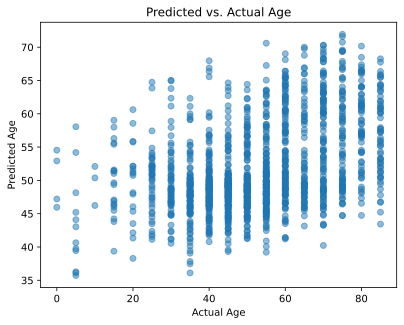

In [ ]:
plt.scatter(actual_values2, predictions2, alpha=0.5)
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs. Actual Age")
plt.show()